In [1]:
%matplotlib inline
from muscle_printing import *
from pathplanner import *
import math

TOOL = { # ratio between extruders
    CONDUCTIVE:[0, 0.5, 0, 0.5],
    MUSCLE:[0.5, 0, 0,  0.5],
    SKIN:[0, 0.5, 0.5,  0]
}
D = 22.63
# d = 1.75 # gauge14
# d = 1.15  # gauge16
d = 0.99 # guage18

# works: 'feedrate_move':600
# 'feedrate_quickmove':7000,
gcode_para = { # G code parameters
    'D':D,
    'd':d,
    'applied_percentage':1,
    'TOOL':TOOL,
    'dump_location':[160, 100, 75],
    'feedrate_move':600,
    'feedrate_quickmove':6000,
    'feedrate_extrude':(d**2) / (330**2),
    'total_volume_change':3900.0, # [(mm)^3]
    'max_reuse_volume':1500,
    }
###################################################################################################

In [2]:
# lines_list = [[2,np.array([[-10,-10,0,0],[10,-10,0,0],[10,10,0,0],[-10,10,0,0],[-10,-10,0,0]]),
#                np.array([[-20,-20,0,0],[20,-20,0,0],[20,20,0,0],[-20,20,0,0],[-20,-20,0,0]])]]
# %matplotlib notebook
# plot_lines_list(lines_list)

In [3]:
gcode_para['feedrate_extrude']

9e-06

In [4]:
# # for two materials
# initial_gcode = ''.join(['G29 S1; load probe setting\n',
#     'F{0}\n'.format(gcode_para['feedrate_quickmove']),
#     'G0 X{0} Y{1} Z{2}\n'.format(gcode_para['dump_location'][0],
#                                  gcode_para['dump_location'][1],
#                                  gcode_para['dump_location'][2]),
#     'G1 F{0}\nG1 E0:5:5:0 F{1}\nG4 P6000\nG0 F{2}\n'.format(gcode_para['feedrate_extrude']*1.5,gcode_para['feedrate_extrude'],gcode_para['feedrate_quickmove'])])
# print(initial_gcode)
# # F0.4624 for extrusion

# # for one material only!
# initial_dump_amount = 6.2

# for two material
initial_dump_amount = 10

initial_gcode = ''.join([
#     'G29 S1; load probe setting\n',
    'G92 Z0;set current z as z=0\n',
    'F{0}\n'.format(gcode_para['feedrate_quickmove']),
    'G0 X{0} Y{1} Z{2}\n'.format(gcode_para['dump_location'][0],
                                 gcode_para['dump_location'][1],
                                 gcode_para['dump_location'][2]),
    multipledumping(amount = initial_dump_amount,extruder=TOOL[SKIN],feedrate_extrude = gcode_para['feedrate_extrude'],
                    delta = 0.1,wait = 200,lastWait = 35000),
    'G0 F{0:.8f}\n'.format(gcode_para['feedrate_quickmove'])])
print(initial_gcode)


G92 Z0;set current z as z=0
F6000
G0 X160 Y100 Z75
G1 F0.000009
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.00

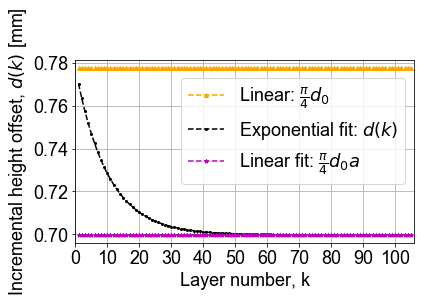

total_height>=74.217


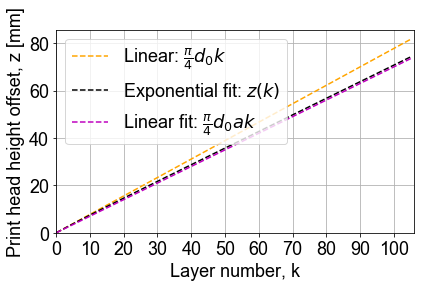

74.21721963673679


In [5]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rcParams
fontsize = 18
rcParams['font.family'] = 'arial'
rcParams['xtick.labelsize'] = fontsize
rcParams['ytick.labelsize'] = fontsize
rcParams['axes.labelsize'] = fontsize
rcParams['legend.fontsize'] = fontsize

def height_vector(num_layers,layer_height,z_start,a=0.95,b=0.33):
    """
    height_vector return the z height for printing each layer.
    num_layers is the total number of layer
    layer_height is the ideal layer height, usually it is the printer tip diameter
    z_start is the starting Z height
    b controls the speed of layer height transition
    a is the final layer height
    @jacobjoseph;@boxiXia
    """
    k = np.arange(0,num_layers)
    z_k = z_start + layer_height*(k*a+(1-a)*np.exp(-b)*(1-np.exp(-b*k))/(1-np.exp(-b)))
    cylinder_height = z_k[-1]-z_k[0]
    print("total_height>={0:.3f}".format(cylinder_height))
    return(z_k)

def diff_height_vector(num_layers,layer_height,z_start,a=0.7,b=0.33):
    """
    diff_height_vector return the individual z height for printing each layer.
    num_layers is the total number of layer
    layer_height is the ideal layer height, usually it is the printer tip diameter
    z_start is the starting Z height
    b controls the speed of layer height transition
    a is the final layer height
    @jacobjoseph;@boxiXia
    """
    k = np.arange(0,num_layers)
    z_ki = layer_height*(a+(1-a)*np.exp(-k*b))
    return(z_ki)

# num_layers = 11
# layer_height =np.pi/4*d # np.pi/4 = 0.785
# z_start = 0
# a = 0.93 
# b = 0.2

num_layers = 106
layer_height =np.pi/4*d # np.pi/4 = 0.785
z_start = 0
# # # this works
# a = 0.94 
# b = 0.1

a = 0.9 
b = 0.1
markersize=4
k = np.arange(0,num_layers)
z_ki = diff_height_vector(num_layers,layer_height,z_start,a=a,b=b)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k[1:],layer_height*np.ones_like(k)[1:],'^--', label='Linear: $\\frac{\pi}{4}d_0$',c='orange', markersize=markersize)
ax.plot(k[1:],z_ki[1:],'.--', label='Exponential fit: $d(k)$',c='k', markersize=markersize)
ax.plot(k[1:],layer_height*a*np.ones_like(k)[1:],'*--', label='Linear fit: $\\frac{\pi}{4}d_0a$',c='m', markersize=markersize)
# ax.xaxis.set_minor_locator(AutoMinorLocator(2))# minor ticks
ax.set_xlim([1,num_layers])
ax.set_xticks(np.arange(0,num_layers+1,num_layers//10))
# ax.set_ylim([.728,.78])
# ax.set_title('Z height Adjustment')
ax.set_xlabel('Layer number, k')
ax.set_ylabel('Incremental height offset, $d(k)$ [mm]')
ax.grid(True)
plt.legend(fontsize=18,loc='upper right', bbox_to_anchor=(1, 0.95))
plt.tight_layout()
plt.savefig('Z height Adjustment incremental_a{0}_b{1}.svg'.format(a,b),bbox_inches='tight')
plt.savefig('Z height Adjustment incremental_a{0}_b{1}.png'.format(a,b),dpi=300)#,bbox_inches='tight')
plt.show()

z_k = height_vector(num_layers,layer_height,z_start,a=a,b=b)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k,k*layer_height,'--', label='Linear: $\\frac{\pi}{4}d_0k$',c='orange')
ax.plot(k,z_k,'--', label='Exponential fit: $z(k)$',c='k')
ax.plot(k,k*layer_height*a,'--', label='Linear fit: $\\frac{\pi}{4}d_0ak$',c='m')
# ax.xaxis.set_minor_locator(AutoMinorLocator(2))# minor ticks
ax.set_xticks(np.arange(0,num_layers+1,num_layers//10))
ax.set_xlim([0,num_layers])
ax.set_ylim(0)
# ax.set_title('Z height Adjustment')
ax.set_xlabel('Layer number, k')
ax.set_ylabel('Print head height offset, z [mm]')
ax.grid(True)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('Z height Adjustment_a{0}_b{1}.svg'.format(a,b),bbox_inches='tight')
plt.savefig('Z height Adjustment_a{0}_b{1}.png'.format(a,b),dpi=300)#,bbox_inches='tight')
plt.show()
print(z_k[-1])

In [6]:
# z_k[39]-29.04754867262477

# polygon

In [7]:
def Polygon(a,d,center,n,phase=0):
    alpha = np.pi/n
    R = a/np.cos(alpha)
    t = np.linspace(phase,phase+2*np.pi,n+1)
    points_x = R*np.cos(t) + center[0]
    points_y = R*np.sin(t) + center[1]
    points = np.stack((points_x, points_y), axis=-1)
    return points

# points =Polygon(a = 10, d = 1, center = [0,0],n = 5,phase = np.pi/6)
# fig, ax = plt.subplots()
# ax.plot(points[:,0],points[:,1],'r')
# plt.axis('equal')
# plt.show()

def Arc(r,angle, center = [0,0],phase = 0,resolution = 1):
    """
    return a numpy array of arc [[x0,y0],[x1,y1],...]
    r - radius of the arc
    center - center of the arc,default: [0,0]
    phase - the middle angle of the arc
    resolution - maximum distance of each section
    """
    angle_start = phase - angle/2
    angle_end = phase + angle/2
    n = int(max(r*angle/resolution+1,5))
    t = np.linspace(angle_start, angle_end,n)
    points_x = r*np.cos(t)+center[0]
    points_y = r*np.sin(t)+center[1]
    points = np.stack((points_x, points_y), axis=-1)
    return points

# center = [0,0]
# points =Arc(r = 1,angle = np.pi/2, center = center,phase = 0,resolution = 0.1)
# fig, ax = plt.subplots()
# ax.plot(points[:,0],points[:,1],'r')
# ax.plot(center[0],center[1],'*')
# ax.plot([center[0],points[0,0]],[center[1],points[0,1]])
# ax.plot([center[0],points[-1,0]],[center[1],points[-1,1]])
# plt.axis('equal')
# plt.grid()
# plt.show()

def PolygonWithFillet(a,center,n,phase=0,fillet = 5, resolution = 2):
    alpha = np.pi/n
    R = a/np.cos(alpha)# distance of polygon-center-to-vertex
    t = np.linspace(phase,phase+2*np.pi,n+1)
    b = (a-fillet)/a # ratio of golygon-center-to-fillet-center and polygon-center-to-vertex
    points = [Arc(r = fillet,angle = alpha*2, center = [b * R*np.cos(ti),b * R*np.sin(ti)],phase = ti,resolution = resolution)
             for ti in t[:-1]]
    points.append(np.array([points[0][0]]))# last point = first point
    points = np.vstack(points)
    points = points+np.array([center[:2]])
    return points
# points =PolygonWithFillet(a = 10,center = [0,0],n = 4,phase=np.pi/4,fillet = 3, resolution = 2)
# # points = shortenPoints(points,d=8)
# fig, ax = plt.subplots()
# ax.plot(points[:,0],points[:,1],'r')
# plt.axis('equal')
# plt.grid()
# plt.show()

def shortenPoints(points,d):
    n = len(points)
    total_len = 0
    for i in range(n-1,0,-1):
        current_len = np.linalg.norm(points[i]-points[i-1])
        total_len = total_len+current_len
        if total_len>d:
            last_point = points[i]*(total_len-d)/current_len + points[i-1]*(current_len-total_len+d)/current_len
            break
#     print(i)
    return np.vstack((points[:i],[last_point]))
# points =PolygonWithFillet(a = 10,center = [5,10],n = 3,phase=0,fillet = 3, resolution = 2)
# points = shortenPoints(points,d=8)
# fig, ax = plt.subplots()
# ax.plot(points[:,0],points[:,1],'r')
# plt.axis('equal')
# plt.grid()
# plt.show()

In [8]:
def multiplePolygonWithFillet(z,material,a,layer_width,center,n,num_rounds,phase=0,fillet = 5,
                              fillet_max = None,reverse=False, resolution = 2,tip_lift = None,
                             transition_offset=-0.1):
    """
    return line_list in the form of [material,polygon#1,polygon#2,..],
    polygon#i in the form of np.array([[x0,y0,z],[x1,y1,z],[x2,y2,z]...])
    Parameters:
        z          - height of the layer from the build plate
        maerial    - a number representing the type of material to be extruded
        a          - ratius of the the first(smallest) polygon's inscribed circle
        layer_width- width of the layer, ussully is the tip diameter
        center     - center of the polygon
        num_rounds - number of polygons
        n          - shape of the polygon, e.g triangle(n=3),square(n = 4), pentagon(n = 5)...
        fillet     - the radius for the fillet on the first(smallest) polygon
        reverse    - if true, go from the smallest polygon to the largest polygon
        resolution - minimum distance of each section
        tip_lift   - amount of tip lift after finishing the lines
    
    """
    line_list = []
    shortened_distance = transition_offset*layer_width
    for i in range(num_rounds):
        fillet_i = fillet+layer_width*i
        if fillet_max is not None:
            fillet_i = min(fillet_i,fillet_max)
        points = shortenPoints(PolygonWithFillet(a+layer_width*i,center,n,phase,fillet_i, resolution),shortened_distance)
        line_list.append(np.hstack((points,z*np.ones((len(points),1)))))
        
    if reverse:
        line_list = [np.flipud(line) for line in reversed(line_list)]
    if tip_lift:
        last_point = np.array(line_list[-1][-1])
        last_point[2] = last_point[2]+tip_lift
        line_list[-1] = np.vstack((line_list[-1],last_point))
        
    line_list.insert(0,material)    
    return line_list

# line_list =multiplePolygonWithFillet(z=0,
#                                      material =SKIN,
#                                      a=4,
#                                      layer_width = 1,
#                                      center =(0,0),
#                                      n = 5,
#                                      num_rounds =20,
#                                      phase=np.pi/4,
#                                      fillet = 0,
#                                      fillet_max = 5,
#                                      reverse=True, 
#                                      resolution = 1,
#                                      tip_lift = 1)
# plot_lines_list([line_list])

In [9]:
# script to print points in the sprial
# current paramters work perfectly - print was succesfful 
# Feedrate of 800 is optimal for prefect print
# 16 Gauge tip was used
# 00-35 was used
# .4 precision on decimal places used in toolpath
# SKIN = 2 # defined in muscle_printing.py
# MUSCLE = 1
# CONDUCTIVE = 0


# intial parameters
center = [0,0]
layer_height = np.pi/4*d
# layer_height = d
layer_width = d
resolution = 3
# z_start =2.4+0.6
z_start =0.6
num_layers = 40 # for height of x mm
cylinder_height = layer_height*num_layers

# Adjusting for sagging in z height
# d is vector containg the adjusted z height for each layer going up
z_list = height_vector(num_layers,layer_height,z_start,a = 0.83,b = 0.25)

# parameters for layer to cover entire diameter
k_full = 12 # will give a cylinder diamter of 40 mm

k_additional = 8
#paramters for layer to cover outer two circle of spiral
k_outside = 3
start_outside = (k_full-k_outside)*layer_width

angle_diff = np.pi/180*3
polygon_shape = 3
# lines_list_1 = [SKIN]
lines_list_1 = []
phase_start = np.pi/3
tip_lift=layer_height/2
for i in range(num_layers):
    if i==0:
        line = multiplePolygonWithFillet(z=z_list[i],
                                     material =SKIN,
                                     a=3,
                                     layer_width = layer_width,
                                     center =center,
                                     n = polygon_shape,
                                     num_rounds =14,
                                     phase=phase_start,
                                     fillet = 0,
                                     fillet_max = None,
                                     reverse=True, 
                                     resolution = 1,
                                     tip_lift = tip_lift)      
    else:
        line = multiplePolygonWithFillet(z=z_list[i],
                                     material =SKIN,
                                     a=6.5,
                                     layer_width = layer_width,
                                     center =center,
                                     n = polygon_shape,
                                     num_rounds =4,
                                     phase=phase_start+angle_diff*(i-1),
                                     fillet = 0.5,
                                     fillet_max = 3.5,
                                     reverse=True, 
                                     resolution = 1,
                                     tip_lift = tip_lift)
    lines_list_1.append(line)

# add muscle
i = -1
line = multiplePolygonWithFillet(z=z_list[i],
                                 material =MUSCLE,
                                 a=0.8,
                                 layer_width = layer_width,
                                 center =center,
                                 n = polygon_shape,
                                 num_rounds =5,
                                 phase=phase_start+angle_diff*(i-1),
                                 fillet = 0.1,
                                 fillet_max = 0.5,
                                 reverse=True, 
                                 resolution = 1,
                                 tip_lift = tip_lift,
                                 transition_offset=0)
for i in range(num_layers):
    lines_list_1.append(line)
    
lines_list = lines_list_1    


total_height>=25.634


In [25]:
def plot_lines_list(lines_list):
    """plot given a lines_list,which is in the format of 
    [[Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    [Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    [Material#,nx3_numpy_array,nx3_numpy_array,nx3_numpy_array...],
    .....
    ]
    @boxiXia
    """
    fig = plt.figure(figsize=(4,4),dpi=300)
#     fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for lines in lines_list:
        for k in range(1,len(lines)):
            ax.plot(lines[k][:,0],lines[k][:,1],lines[k][:,2],c=COLORS[lines[0]],linewidth=.5)
            try:
                ax.plot([lines[k][-1,0],lines[k + 1][0,0]],[lines[k][-1,1],lines[k + 1][0,1]],[lines[k][-1,2],lines[k + 1][0,2]],'m',linewidth=.5)
            except IndexError:
                #last lines
                pass
    plt.tight_layout()
    return ax


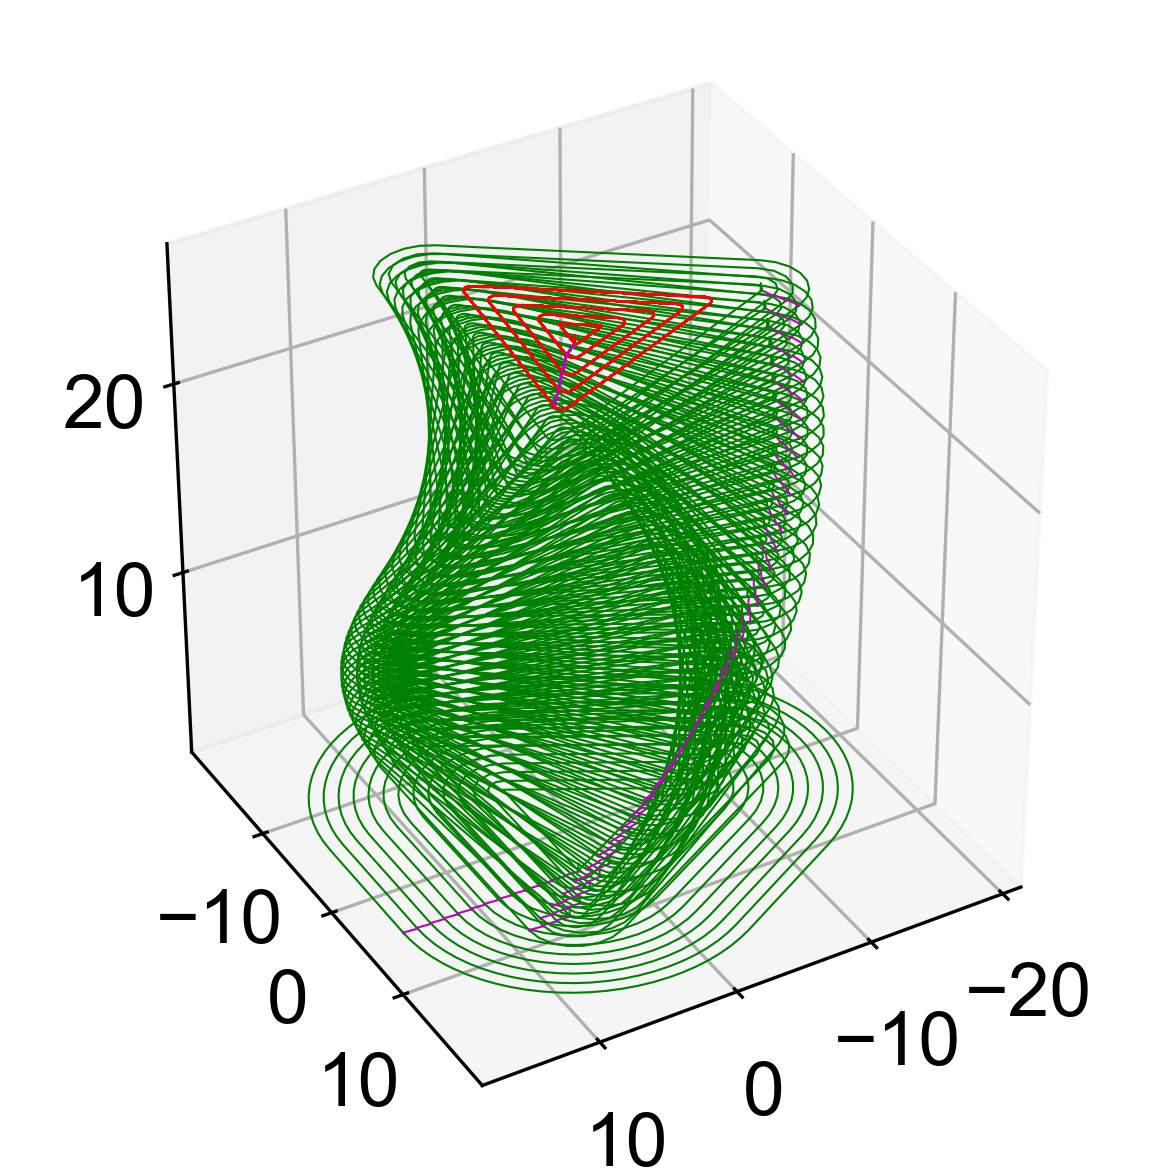

In [32]:
%matplotlib inline
ax = plot_lines_list(lines_list)
ax.view_init(elev=35., azim=60)
plt.savefig('spiral_triangle.tif',dpi=300)

In [47]:

g_code_strings = lines_list_to_gcode_strings(lines_list,gcode_para)
# dumping:
#g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:0:0:0 F0.4624\nG1 E0:9:9:0 F0.4624\nG4 P6000\nG0 F1800')

g_code_strings.insert(0,initial_gcode)

# only skin:
# g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:0:0:0 F0.4624\nG1 E0:8:8:0 F0.4624\nG4 P6000\nG0 F1800')



# initialization
init = initilize_parameters(4,is_absolute=True,is_mm=True,feedrate = 1500 )
g_code_strings.insert(0,init)


s = ''.join(g_code_strings)
# f = open('/Users/davidjoseph/Google Drive/3D printing soft muscle/G-Code/spiral.g','w')
f = open('./gcode/polygon.g','w')
f.write(s)
f.close()
print(s)

T4
G90
G21
G0 F1500
M83
G92 Z0;set current z as z=0
F6000
G0 X160 Y100 Z75
G1 F0.000009
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0

In [11]:
# # rotatating square also works
# # intial parameters
# center = [0,100]
# layer_height = np.pi/4*d
# # layer_height = d
# layer_width = d
# resolution = 3
# # z_start =2.4+0.6
# z_start =0.55
# num_layers = 60 # for height of x mm
# cylinder_height = layer_height*num_layers

# # Adjusting for sagging in z height
# # d is vector containg the adjusted z height for each layer going up
# z_list = height_vector(num_layers,layer_height,z_start,a = 0.83,b = 0.2)

# # parameters for layer to cover entire diameter
# k_full = 12 # will give a cylinder diamter of 40 mm

# k_additional = 8
# #paramters for layer to cover outer two circle of spiral
# k_outside = 3
# start_outside = (k_full-k_outside)*layer_width

# angle_diff = np.pi/180*4
# polygon_shape = 4
# # lines_list_1 = [SKIN]
# lines_list_1 = []
# phase_start = np.pi/3
# tip_lift=layer_height/2
# for i in range(num_layers):
#     if i==0:
#         line = multiplePolygonWithFillet(z=z_list[i],
#                                      material =SKIN,
#                                      a=3,
#                                      layer_width = layer_width,
#                                      center =center,
#                                      n = polygon_shape,
#                                      num_rounds =14,
#                                      phase=phase_start,
#                                      fillet = 0,
#                                      fillet_max = None,
#                                      reverse=True, 
#                                      resolution = 1,
#                                      tip_lift = tip_lift)      
#     else:
#         line = multiplePolygonWithFillet(z=z_list[i],
#                                      material =SKIN,
#                                      a=6.5 - i*0.08,
#                                      layer_width = layer_width,
#                                      center =center,
#                                      n = polygon_shape,
#                                      num_rounds =4,
#                                      phase=phase_start+angle_diff*(i-1),
#                                      fillet = 0.5,
#                                      fillet_max = 3.5-i*0.03,
#                                      reverse=True, 
#                                      resolution = 1,
#                                      tip_lift = tip_lift)
#     lines_list_1.append(line)
    
# lines_list = lines_list_1    
# %matplotlib notebook
# plot_lines_list(lines_list)

In [32]:
# # this works! print time=25min

# # intial parameters
# center = [0,100]
# layer_height = np.pi/4*d
# # layer_height = d
# layer_width = d
# resolution = 3
# # z_start =2.4+0.6
# z_start =0.55
# num_layers = 80 # for height of x mm
# cylinder_height = layer_height*num_layers

# # Adjusting for sagging in z height
# # d is vector containg the adjusted z height for each layer going up
# z_list = height_vector(num_layers,layer_height,z_start,a = 0.84,b = 0.2)

# # parameters for layer to cover entire diameter
# k_full = 12 # will give a cylinder diamter of 40 mm

# k_additional = 8
# #paramters for layer to cover outer two circle of spiral
# k_outside = 3
# start_outside = (k_full-k_outside)*layer_width

# angle_diff = np.pi/180*3
# polygon_shape = 3
# # lines_list_1 = [SKIN]
# lines_list_1 = []
# phase_start = np.pi/3
# tip_lift=layer_height/2
# for i in range(num_layers):
#     if i==0:
#         line = multiplePolygonWithFillet(z=z_list[i],
#                                      material =SKIN,
#                                      a=3,
#                                      layer_width = layer_width,
#                                      center =center,
#                                      n = polygon_shape,
#                                      num_rounds =14,
#                                      phase=phase_start,
#                                      fillet = 0,
#                                      fillet_max = None,
#                                      reverse=True, 
#                                      resolution = 1,
#                                      tip_lift = tip_lift)      
#     else:
#         line = multiplePolygonWithFillet(z=z_list[i],
#                                      material =SKIN,
#                                      a=6.5 - i*0.07,
#                                      layer_width = layer_width,
#                                      center =center,
#                                      n = polygon_shape,
#                                      num_rounds =4,
#                                      phase=phase_start+angle_diff*(i-1),
#                                      fillet = 0.5,
#                                      fillet_max = 3.5-i*0.03,
#                                      reverse=True, 
#                                      resolution = 1,
#                                      tip_lift = tip_lift)
#     lines_list_1.append(line)
    
# lines_list = lines_list_1    


In [33]:
# %matplotlib notebook
# plot_lines_list(lines_list)

# sprial

In [34]:
def spiral_0(center,z,k,start,layer_width,resolution,material,reverse=False,phase = 0):
    """CENTER is the [x y] cordinates for the center of the cylinder. 
    z is the height of the layer from the build plate. K is the number of times 
    the spiral makes a 360 degree rotation. START is the location of the start point 
    of the sprial from the center in the y direction (is it typically a multiple of the 
    layer width or syringe tip diameter). LAYER WIDTH is the distance between lines in 
    spiral(typically the diameter of the syringe tip). Resolution is the number of straight 
    segments in 360 degress of the one sprial turn(recommended is 25 to 20).Resolution is the 
    maximum distance between neighbor points."""
    
    line_list = []
    phase_start = phase
    phase_end = phase_start+2*np.pi
    for i in range(k):
        r_start = start+layer_width*i
        r_end =   start+layer_width*(i+1)
        r_avg = (r_start+r_end)/2
        n = int(max(25,r_avg*2*np.pi/resolution))
        r = np.linspace(r_start,r_end,n)
        line  = np.empty((n,3))
        t = np.linspace(phase_start,phase_end,n)
        line[:,0] = center[0]+r*np.cos(t)
        line[:,1] = center[1]+r*np.sin(t)
        line[:,2] = z
        line_list.append(line)
    if reverse:
        line_list = [np.flipud(line) for line in reversed(line_list)]
        
#     line_list = [material,np.vstack(line_list)]
    line_list.insert(0,material)
    return line_list

# center = [0,0]
# k_full = 10
# layer_width = 1
# resolution = 1

# s1 = spiral_0(center,z=0,k = k_full,start = 0,layer_width = layer_width,resolution =resolution,material = SKIN,reverse = False)
# plot_lines_list([s1])
# s2 = spiral_0(center,z=0,k = k_full,start = 0,layer_width = layer_width,resolution =resolution,material = SKIN,reverse = True)
# plot_lines_list([s2])

In [35]:
def spiral(center,z,k,start,layer_width,resolution,material,reverse=False,phase = 0,transition_ratio = 0.5,tip_lift = None):
    """CENTER is the [x y] cordinates for the center of the cylinder. 
    z is the height of the layer from the build plate. K is the number of times 
    the spiral makes a 360 degree rotation. START is the location of the start point 
    of the sprial from the center in the y direction (is it typically a multiple of the 
    layer width or syringe tip diameter). LAYER WIDTH is the distance between lines in 
    spiral(typically the diameter of the syringe tip). Resolution is the maximum distance between
    neighbor points.MATERIAL is a number representing the type of material to be extruded, 
    this will select the two extruders to be used during the print.
    transition_ratio is between [0,1] to control the how tangent the transition is,
    if transition_ratio==1 then make tangent transition between neighboring circles
    tip_lift is the amount of tip lift after finishing the spiral/circles"""
    transition_distance = 0*d
    delta_phase = 0
    line_list = []
    for i in range(k):
        r = start+layer_width*i
        if(i>0):
            r_previous = start+layer_width*(i-1)
            delta_phase =delta_phase+ (np.arccos(r_previous/r)- np.arcsin(transition_distance/r_previous))*transition_ratio
        phase_start = phase+delta_phase
        phase_end = phase_start + 2*np.pi - transition_distance/r
        n = int(max(25,r*2*np.pi/resolution))
#         print(n)
        t = np.linspace(phase_start,phase_end,n)
        line  = np.empty((n,3))
        line[:,0] = center[0]+r*np.cos(t)
        line[:,1] = center[1]+r*np.sin(t)
        line[:,2] = z
        line_list.append(line)
    if reverse:
        line_list = [np.flipud(line) for line in reversed(line_list)]
    if tip_lift:
        last_point = np.array(line_list[-1][-1])
        last_point[2] = last_point[2]+tip_lift
        line_list[-1] = np.vstack((line_list[-1],last_point))
    line_list.insert(0,material)
    return line_list

# plot_lines_list([spiral(center = [0,0],z = 0 ,k = 10 ,start = 5 ,layer_width = d,
#                      resolution = 4 ,material =SKIN,reverse=True,phase = 0,tip_lift=d)])

In [36]:
# script to print points in the sprial
# current paramters work perfectly - print was succesfful 
# Feedrate of 800 is optimal for prefect print
# 16 Gauge tip was used
# 00-35 was used
# .4 precision on decimal places used in toolpath
# SKIN = 2 # defined in muscle_printing.py
# MUSCLE = 1
# CONDUCTIVE = 0


# intial parameters
center = [0,100]
layer_height = np.pi/4*d
# layer_height = d
layer_width = d
resolution = 3
# z_start =2.4+0.6
z_start =0.65
# num_layers = 104 # for height of x mm
# # parameters for layer to cover entire diameter
# k_full = 12
# k_wall = 3
# k_additional = 8

num_layers = 40 # for height of x mm
k_full = 13
k_wall = 3
k_additional = 5

cylinder_height = layer_height*num_layers

# Adjusting for sagging in z height
# d is vector containg the adjusted z height for each layer going up
z_list = height_vector(num_layers,layer_height,z_start,a = 0.86,b = 0.15)




#paramters for layer to cover outer two circle of spiral

start_outside = (k_full-k_wall)*layer_width

base_layers = 1
# lines_list_1 = [SKIN]
lines_list = []


# s2 = spiral_0(center,z=0,k = k_full,start = 0,layer_width = layer_width,resolution =resolution,material = SKIN,reverse = True)


for i in range(num_layers):
    if i==0:
        line = spiral_0(center,z_list[i],k_full+k_additional,0,layer_width,resolution,SKIN,reverse=True,phase = 0)  
    else:
        line = spiral(center,z_list[i],k_wall,start_outside,layer_width,resolution,SKIN,reverse=True,phase = -i*np.pi/5,tip_lift=layer_height/2)     

    lines_list.append(line)


# Muscle extrusion
# do same spiral motion for same number of layers but don't change the z height

num_mucscle_layer = math.ceil((z_list[-1]-z_list[0])/layer_height)
line = spiral(center,z_list[-1]+0.1,k_full-k_wall-1,1,layer_width,resolution,MUSCLE,reverse=True,phase = 0,tip_lift=0)     
for i in range(num_mucscle_layer):
    lines_list.append(line)
    
# # top layer - skin
# lines_list_3 = [SKIN]
# for i in range(num_layers-base_layers,num_layers):
#     if i % 2 == 0:
#         line = spiral(center,d[i],k_full,start_full,layer_width,resolution,SKIN)[1]
#     elif i % 2 != 0:
#         line = np.flip(spiral(center,d[i],k_full,start_full,layer_width,resolution,SKIN)[1],0)
#     lines_list_3.append(line)

# lines_list = [lines_list_1,lines_list_2,lines_list_3]
# # lines_list = [lines_list_1,lines_list_2]
# # lines_list = [lines_list_1]

total_height>=26.750


In [37]:
# # this works!
# # intial parameters
# center = [0,100]
# layer_height = np.pi/4*d
# # layer_height = d
# layer_width = d
# resolution = 3
# # z_start =2.4+0.6
# z_start =0.5
# num_layers = 104 # for height of x mm
# cylinder_height = layer_height*num_layers

# # Adjusting for sagging in z height
# # d is vector containg the adjusted z height for each layer going up
# z_list = height_vector(num_layers,layer_height,z_start,a = 0.86,b = 0.1)

# # parameters for layer to cover entire diameter
# k_full = 12 # will give a cylinder diamter of 40 mm
# k_additional = 8
# #paramters for layer to cover outer two circle of spiral
# k_wall = 3
# start_outside = (k_full-k_wall)*layer_width
# base_layers = 1
# # lines_list_1 = [SKIN]
# lines_list = []

# for i in range(num_layers):
#     if i==0:
#         line = spiral_0(center,z_list[i],k_full+k_additional,0,layer_width,resolution,SKIN,reverse=True,phase = 0)  
#     else:
#         line = spiral(center,z_list[i],k_wall,start_outside,layer_width,resolution,SKIN,reverse=True,phase = -i*np.pi/5,tip_lift=layer_height/2)     

#     lines_list.append(line)

In [38]:
# # %matplotlib notebook
# plot_lines_list(lines_list)

In [39]:

g_code_strings = lines_list_to_gcode_strings(lines_list,gcode_para)
# dumping:
#g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:0:0:0 F0.4624\nG1 E0:9:9:0 F0.4624\nG4 P6000\nG0 F1800')

g_code_strings.insert(0,initial_gcode)

# only skin:
# g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:0:0:0 F0.4624\nG1 E0:8:8:0 F0.4624\nG4 P6000\nG0 F1800')

# initialization
init = initilize_parameters(4,is_absolute=True,is_mm=True,feedrate = 1500 )
g_code_strings.insert(0,init)


s = ''.join(g_code_strings)
# f = open('/Users/davidjoseph/Google Drive/3D printing soft muscle/G-Code/spiral.g','w')
f = open('./gcode/spiral.g','w')
f.write(s)
f.close()
print(s)

T4
G90
G21
G0 F1500
M83
G92 Z0;set current z as z=0
F6000
G0 X160 Y100 Z75
G1 F0.000009
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0

In [40]:
# """check total extusion value for each extruder"""
# from re import split
# # re.findall('[-+]?\d*\.\d+|\d+', 'G1 E-0.0151:-0.0000:-0.0151:-0.0000:5')
# def check_total_extrusion(gcode):
#     e_list = []
#     for line in gcode.split('\n'):
#         try:
#             e_list.append([float(x) for x in split(':',split(' ',split('E',line)[-1])[0])])
#         except ValueError:
#             pass
#     e_list = np.array(e_list)
#     return np.sum(e_list,axis=0)
# f = open('D:/Google Drive/3D printing soft muscle/G-Code/spiral.g','r')
# message = f.read()
# # print(message)
# f.close()
# total_extrusion = check_total_extrusion(message)
# # print('G1 E-{0:0.4f}:-{1:0.4f}:-{2:0.4f}:-{3:0.4f} F300\n'.format(total_extrusion[0],total_extrusion[1],total_extrusion[2],total_extrusion[3]))
# print(total_extrusion)

# Tiangle

In [41]:
def Triangle(a,d,center = [0,0]):
    s =a/ np.sqrt(3)
    return np.array([[center[0],center[1]+s],[center[0]-a/2,center[1]-s/2],[center[0]+a/2,center[1]-s/2],[center[0]+d/np.sqrt(3),center[1]+s-d]])

def MultTriangle(a,d,n,center = [0,0]):
    a_list = a-d*np.sqrt(3)*2*np.arange(0,n)
    return np.vstack([Triangle(ak,d,center) for ak in a_list])

<IPython.core.display.Javascript object>


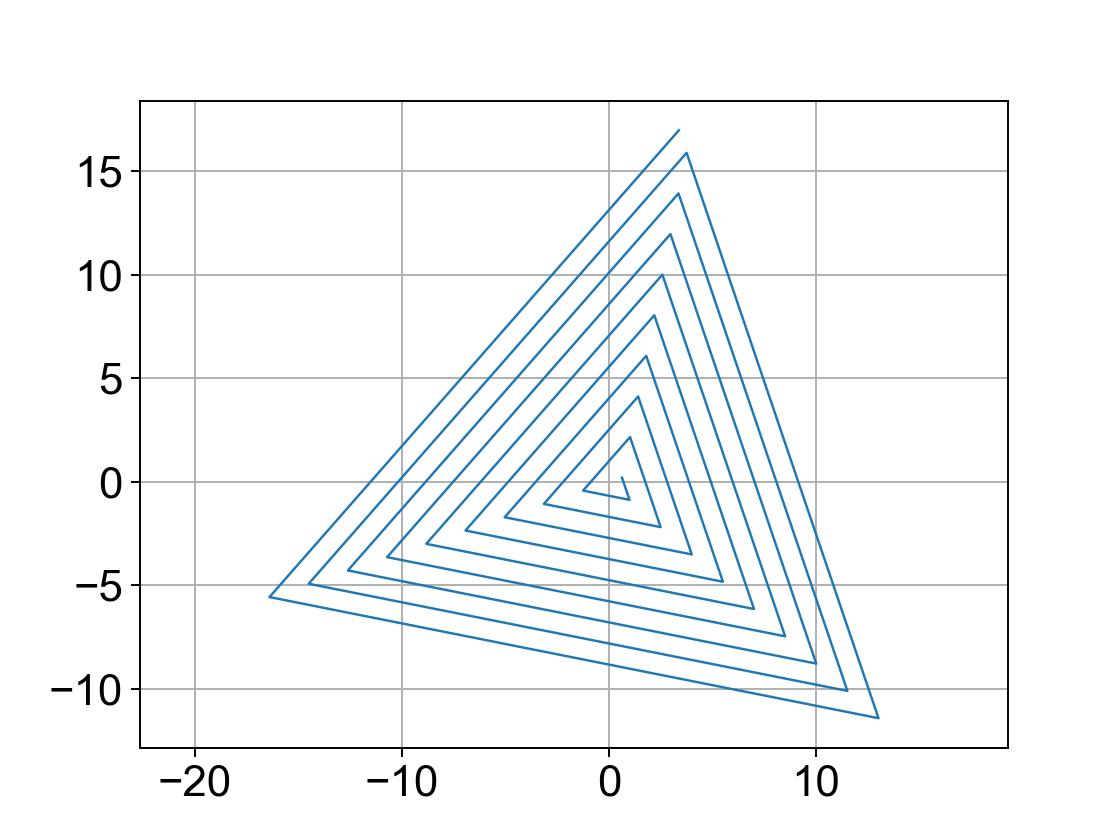

In [42]:
# tr = Triangle(6,1)
center = (0,0)
angle = np.pi/16
tr = np.dot(MultTriangle(a = 30,d = 1,n = 9, center = center),rotation_2d(angle))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tr[:,0],tr[:,1],'-',lineWidth = 1)

ax.grid()
plt.axis('equal') 
plt.show()

In [ ]:
# intial parameters
center = [0,0]
layer_height = np.pi/4*d
# layer_height = d
layer_width = d
# z_start =2.4+0.6
z_start =0.5
num_layers = 100 # for height of x mm
angle_diff = np.pi/180*0.5

# Adjusting for sagging in z height
# d is vector containg the adjusted z height for each layer going up
z_list = height_vector(num_layers,layer_height,z_start,a = 0.9,b = 0.15)

base_layers = 1
lines_list_1 = []
lines_list = []

# add base layer
tr = np.dot(MultTriangle(a = 55,d = d ,n = 12, center = center),rotation_2d(angle_diff*0))
tr_with_z = np.hstack((tr,np.ones((tr.shape[0],1))*z_list[0]))
lines_list_1.append([SKIN,tr_with_z])
# add walls
for i in range(num_layers-base_layers):
    tr = np.dot(MultTriangle(a = 40,d = d ,n = 4, center = center),rotation_2d(angle_diff*i))
    tr_with_z = np.hstack((tr,np.ones((tr.shape[0],1))*z_list[i+1]))
    lines_list_1.append([SKIN,tr_with_z])
    
lines_list = lines_list_1

In [43]:
# # for one material only!
# initial_gcode = ''.join(['G29 S1; load probe setting\n',
#     'F{0}\n'.format(gcode_para['feedrate_quickmove']),
#     'G0 X{0} Y{1} Z{2}\n'.format(gcode_para['dump_location'][0],
#                                  gcode_para['dump_location'][1],
#                                  gcode_para['dump_location'][2]),
#     'G1 F{0}\nG1 E0:3.2:3.2:0 F{1}\nG4 P8000\nG0 F{2}\n'.format(gcode_para['feedrate_extrude'],gcode_para['feedrate_extrude'],gcode_para['feedrate_quickmove'])])
# print(initial_gcode)

g_code_strings = lines_list_to_gcode_strings(lines_list,gcode_para)
# dumping:
#g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:0:0:0 F0.4624\nG1 E0:9:9:0 F0.4624\nG4 P6000\nG0 F1800')

g_code_strings.insert(0,initial_gcode)

# only skin:
# g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:0:0:0 F0.4624\nG1 E0:8:8:0 F0.4624\nG4 P6000\nG0 F1800')



# initialization
init = initilize_parameters(4,is_absolute=True,is_mm=True,feedrate = 1500 )
g_code_strings.insert(0,init)


s = ''.join(g_code_strings)
f = open('D:/Google Drive/3D printing soft muscle/G-Code/triangle.g','w')
f.write(s)
f.close()
print(s)

T4
G90
G21
G0 F1500
M83
G92 Z0;set current z as z=0
F6000
G0 X160 Y100 Z75
G1 F0.000009
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0.000009
G4 P200
G1 E0.000000:0.050000:0.050000:0.000000 F0

## Notes
100 A + 0.1 red + 4 plat cat+ 1.1 Thivex

100 B + 0.1 yellow+ 1.1 Thivex

height adjustment:

    day1:a,b = 0.92,0.08
    
    day2:a,b = 0.90,0.10

### Another iteration
100 A + 0.1 red + 5 plat cat + 1.1 Thivex

100 B + 0.1 yellow + 1.1 Thivex

plat cat is to accelerate the curing,
Thivex is to thicken the material